In [46]:
import dgl.function as fn
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn import SAGEConv
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from dgl.data.utils import load_graphs
import argparse 
import os
import pickle
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import networkx as nx
import dgl

class CNN(nn.Module):
    def __init__(self, conv_param, hidden_units):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=conv_param[0][0], out_channels=conv_param[1], kernel_size=conv_param[0][1], padding='same')
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=conv_param[2])
        self.flatten = nn.Flatten()
        self.input_shape = conv_param[0][2]

        # Détermination de la taille de l'entrée des couches linéaires
        num_conv_features = self._calculate_conv_features(conv_param)
        self.linear_layers = self._create_linear_layers(num_conv_features, hidden_units)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)

        # Appliquer les couches linéaires
        for layer in self.linear_layers:
            x = layer(x)
            x = self.relu(x)
        return x

   
    def _calculate_conv_features(self, conv_param):
        # Calculer le nombre de caractéristiques extraites par les couches de convolution
        dummy_input = torch.zeros((1,conv_param[0][0], *self.input_shape))  # Exemple d'entrée (taille arbitraire)
        conv_output = self.conv1(dummy_input)
        conv_output = self.relu(conv_output)
        conv_output = self.pool(conv_output)
        conv_output = self.flatten(conv_output)
        return conv_output.size(1)
       

    def _create_linear_layers(self, num_conv_features, hidden_units):
        # Créer des couches linéaires en fonction du nombre de caractéristiques extraites par les couches de convolution
        layers = []
        for i in range(len(hidden_units)):
            if i == 0:
                layers.append(nn.Linear(num_conv_features, hidden_units[i]))
            else:
                layers.append(nn.Linear(hidden_units[i-1], hidden_units[i]))
        return nn.ModuleList(layers)


# Define the GCN model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, conv_param,hidden_units):
        super(GCN, self).__init__()
        self.cnn = CNN(conv_param=conv_param, hidden_units=hidden_units)
        self.conv1 = SAGEConv(hidden_units[-1], hidden_size, 'mean')
        self.conv2 = SAGEConv(hidden_size, num_classes, 'mean')

    def forward(self, g, features):
        x = self.cnn(features.unsqueeze(1)).squeeze(1)
        x = F.relu(self.conv1(g, x))
        x = self.conv2(g, x)
        return x


glist, label_dict = load_graphs(os.path.join(input_folder,"origin_word_graph_data.bin"))
dgl_G = glist[0]  

with open(os.path.join(input_folder, 'dataset.pl'), 'rb') as file:
    data = pickle.load(file)

data = data[:1000]

# Initialize the GCN model
in_feats = dgl_G.ndata['features'].shape[1]
hidden_size = 64
num_classes = len(data['label'].unique())  # Number of unique labels
conv_param = [
    # Paramètres de la première couche de convolution
    (1, 3, (20,64)),  # Tuple: (nombre de canaux d'entrée, taille du noyau, forme de l'entrée)
    32,
    # Paramètres de la couche de pooling
    (2)
]


hidden_units = [32, 32]

features = dgl_G.ndata['features']

In [47]:
import dgl.function as fn
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn import SAGEConv
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import os

input_folder= ''
model_path = os.path.join(input_folder,"gnn_model.pth")
loaded_model = GCN(in_feats, hidden_size, num_classes, conv_param, hidden_units)
loaded_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

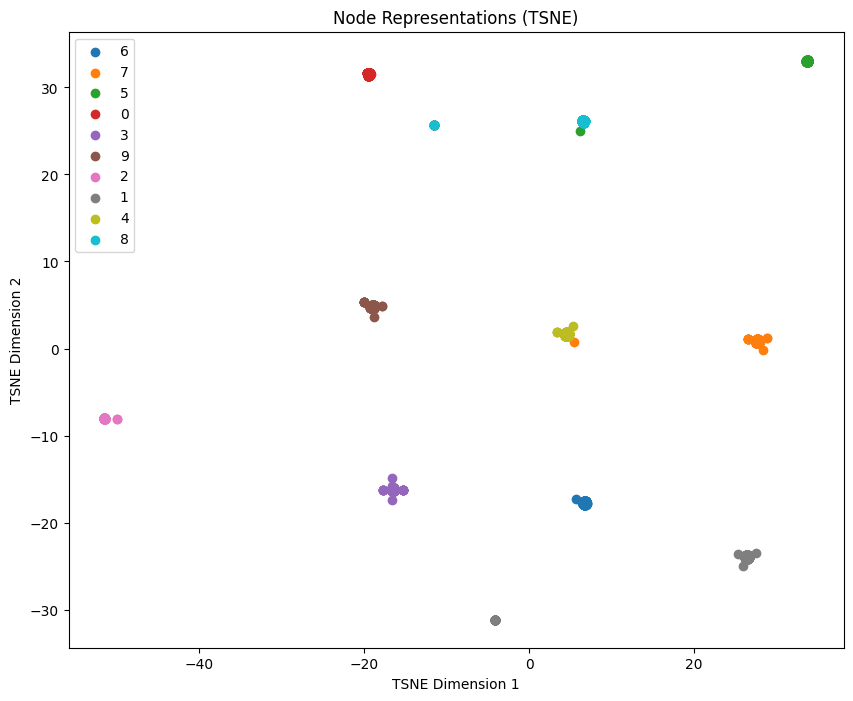

In [48]:
# Extract node representations
with torch.no_grad():
    loaded_model.eval()
    node_embeddings = loaded_model(dgl_G, features).numpy()

# Reduce dimensions for plotting
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

# Plot node representations
plt.figure(figsize=(10, 8))
for i, label in enumerate(data['label'].unique()):
    indices = (data['label'] == label).values
    plt.scatter(node_embeddings_2d[indices, 0], node_embeddings_2d[indices, 1], label=label)
plt.legend()
plt.title('Node Representations (TSNE)')
plt.xlabel('TSNE Dimension 1')
plt.ylabel('TSNE Dimension 2')
plt.show()


In [49]:
model_path = os.path.join(input_folder,"gnn_model_unsup.pth")
loaded_model = GCN(in_feats, hidden_size, num_classes, conv_param, hidden_units)
loaded_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

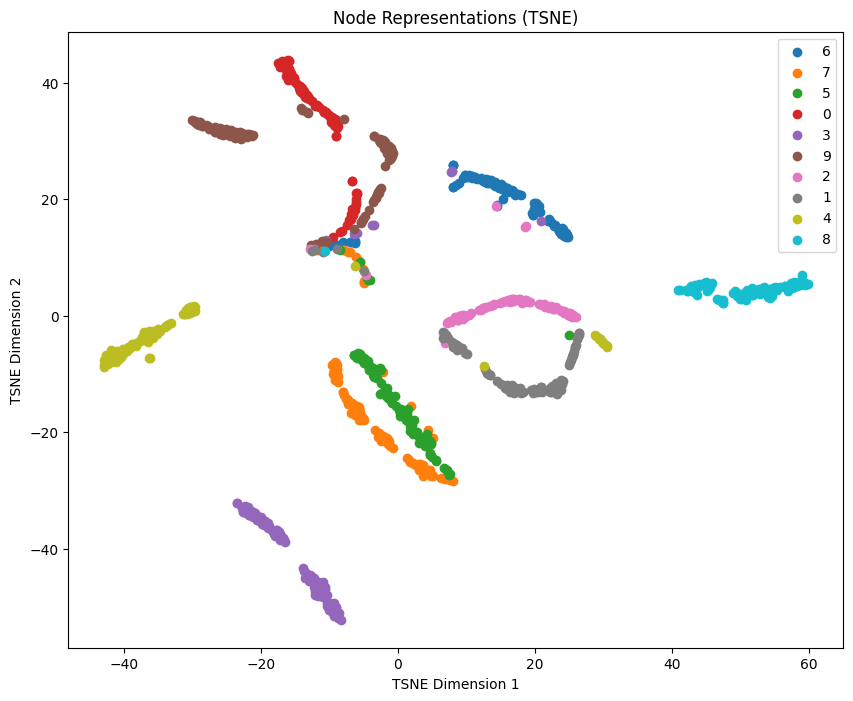

In [50]:
# Extract node representations
with torch.no_grad():
    loaded_model.eval()
    node_embeddings = loaded_model(dgl_G, features).numpy()

# Reduce dimensions for plotting
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

# Plot node representations
plt.figure(figsize=(10, 8))
for i, label in enumerate(data['label'].unique()):
    indices = (data['label'] == label).values
    plt.scatter(node_embeddings_2d[indices, 0], node_embeddings_2d[indices, 1], label=label)
plt.legend()
plt.title('Node Representations (TSNE)')
plt.xlabel('TSNE Dimension 1')
plt.ylabel('TSNE Dimension 2')
plt.show()

In [51]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Supposons que vous avez déjà entraîné votre modèle GCN et que vous avez obtenu les représentations des données
# Vous avez également vos étiquettes dans la variable labels

# Obtenez les représentations des données à partir du modèle GCN
with torch.no_grad():
    loaded_model.eval()
    representations = loaded_model.cnn(features.unsqueeze(1)).squeeze(1).detach().numpy()
labels = data['label']
# Divisez les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(representations, labels, test_size=0.2, random_state=42)

# Initialisez le classifieur SVM
svm_classifier = SVC()

# Entraînez le SVM sur les représentations
svm_classifier.fit(X_train, y_train)

# Prédisez les étiquettes sur l'ensemble de test
y_pred = svm_classifier.predict(X_test)

# Évaluez les performances du SVM en utilisant l'exactitude
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.32
